In [20]:
import h5py
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys

sys.path.insert(0, '../scripts/')


### parameters

In [21]:
run = 58
n_epix = 2

### load files

In [22]:
file_name = '../h5s/run00%d_ALL.tbl'%run
h5file = h5py.File(file_name, 'r')

img = np.array([h5file['epix_sum/epix_1'],h5file['epix_sum/epix_2'],h5file['epix_sum/epix_3'],h5file['epix_sum/epix_4']])
ADUs_hist = np.array(h5file['raw_histogram/epix_%d'%n_epix])
photon_hist = np.array(h5file['histogram/epix_%d'%n_epix])
cspad = np.array(h5file['cspad/sum'])
cspad_Iq = np.array(h5file['cspad/lineout'])
mask_epix = np.load('../masks/mask_r0019_epix%d+borders.npy'%(n_epix))
mask_cspad= np.load('../masks/mask_r0019_cspad+borders.npy')

### Calculation

In [5]:
n_pix = np.sum(mask_epix)
avg_ADUs_hist = np.average(ADUs_hist,axis=0)
avg_photon_hist = np.average(photon_hist,axis=0)
n_bins = avg_ADUs_hist.shape[0]

n_shots = float(ADUs_hist.shape[0])

kbar_avg = avg_photon_hist[1]/n_pix+avg_photon_hist[2]/n_pix
kbar = photon_hist[:,1]/float(n_pix) + 2*photon_hist[:,2]/float(n_pix)

p1 = photon_hist[:,1]/float(n_pix)
p2 = photon_hist[:,2]/float(n_pix)

### CSPAD

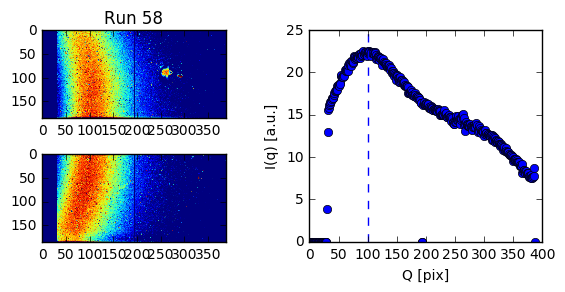

In [19]:
plt.figure(figsize=[6,3])
plt.subplot(2,2,1)
plt.imshow(cspad[0]*mask_cspad[0],vmin=3e5,vmax=0.5e6)
plt.title('Run %d'%run)
plt.xticks()
plt.subplot(2,2,3)
plt.imshow(np.rot90(cspad[1]*mask_cspad[1],2),vmin=3e5,vmax=0.5e6)
#plt.colorbar()

plt.subplot(1,2,2)
s = cspad[0]*mask_cspad[0]/n_shots

Iq_quick = np.average(s,axis=0)
plt.plot(Iq_quick,'o')
plt.axvline(x=100,ls='--')
plt.savefig('/Users/fivos/Desktop/cspad_2.png',dpi=300)

plt.xlabel('Q [pix]')
plt.ylabel('I(q) [a.u.]')
plt.tight_layout()
plt.show()

### ePIX

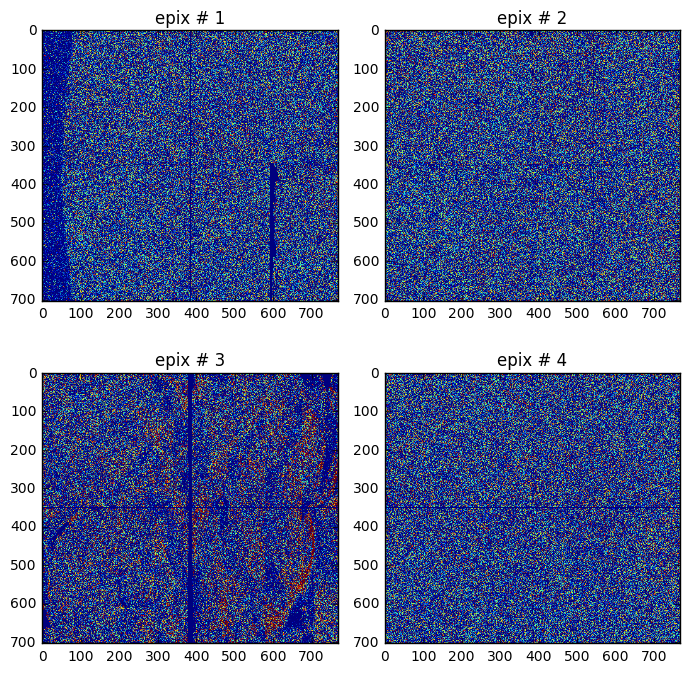

In [23]:
plt.figure(figsize=[7,7])
vmin,vmax = 0,1
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(img[i]/float(n_shots),vmax=vmax,vmin=vmin)
    plt.title('epix # %d'%(i+1))
plt.tight_layout()
plt.show()

### Photon histograms

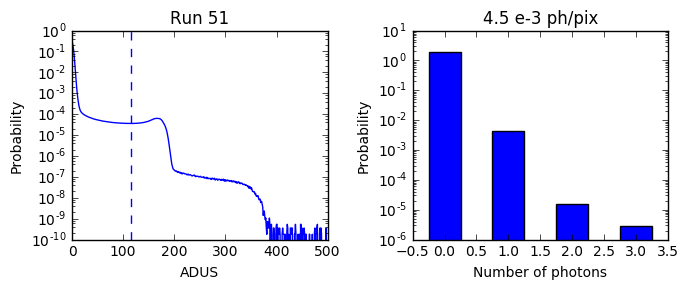

In [24]:
plt.figure(figsize=[7,3])

plt.subplot(1,2,1)
plt.plot(np.arange(n_bins),avg_ADUs_hist/n_pix)
plt.yscale('log',nonposy='clip')
plt.ylabel('Probability')
plt.xlabel('ADUS')
plt.axvline(x=115,ls='--')
plt.title('Run %d'%run)

plt.subplot(1,2,2)
plt.bar(np.arange(4)-0.25,avg_photon_hist/n_pix,width=0.5)
plt.yscale('log',nonposy='clip')
plt.ylabel('Probability')
plt.xlabel('Number of photons')
plt.title('%.1f e-3 ph/pix'%(kbar_avg*1e3))

plt.tight_layout()
plt.savefig('/Users/fivos/Desktop/Adus.png',dpi=300)

plt.show()


### Photon counts vs kbar

In [25]:
def photon_probability(beta,kbar):
    M = 1./beta
    p1 = M*(1+M/kbar)**(-1)*(1+kbar/M)**(-M)
    p2 = M*(M+1)/2*(1+M/kbar)**(-2)*(1+kbar/M)**(-M)
    return p1,p2
kbar_est = np.logspace(-6,-1,5)
p1_0,p2_0 = photon_probability(1e-5,kbar_est)
p1_1,p2_1 = photon_probability(1,kbar_est)

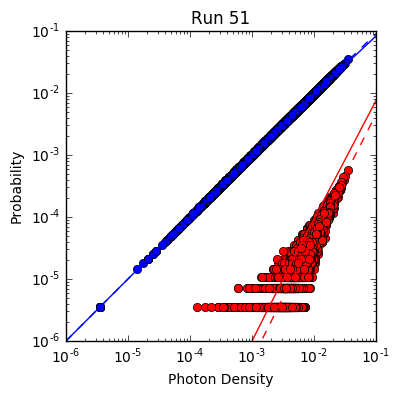

In [26]:
plt.figure(figsize=[4,4])
plt.plot(kbar,p1,'o',c='blue')
plt.plot(kbar,p2,'o',c='red')
plt.plot(kbar_est,p1_1,c='blue')
plt.plot(kbar_est,p2_1,c='red')
plt.plot(kbar_est,p1_0,c='blue',ls='--')
plt.plot(kbar_est,p2_0,c='red',ls='--')
#plt.plot(kbar,photon_hist[:,3],'o',c='green')
plt.yscale('log',nonposy='clip')
plt.xscale('log',nonposy='clip')
plt.ylim(1e-6,1e-1)
plt.ylabel('Probability')
plt.xlabel('Photon Density')
#plt.title('%.1f e-3 ph/pix'%(kbar_avg*1e3))
plt.title('Run %d'%run)
plt.savefig('/Users/fivos/Desktop/counts.png',dpi=300)
plt.show()